<a href="https://colab.research.google.com/github/chanhoGod/MJU-Artificial-intelligence1-DogePredict/blob/master/DOGEPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import matplotlib.ticker as ticker
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from datetime import datetime, timedelta

In [ ]:
arr = []
for i in range(2):
    today = datetime.today() - timedelta(i * 30)  #6시간 간격 2달치 데이터를 가져오기 위해서 api요청으로 180번(30일) * 2번을 요청한다.
    req = requests.get('https://crix-api-endpoint.upbit.com/v1/crix/candles/minutes/240?code=CRIX.UPBIT.KRW-DOGE&count=180&to='+ today.strftime("%Y-%m-%d")+'%2024:00:00')
    arr += req.json()        

#json 데이터화
arr.reverse()                                     #최신 데이터부터 먼저 들어오기 때문에 순서를 역순으로 바꿔준다.
df = pd.DataFrame(arr)                            #pandas.dataFrame으로 가공하기 편한 데이터로 만들어준다.
print(df)


Text(0, 0.5, 'price')

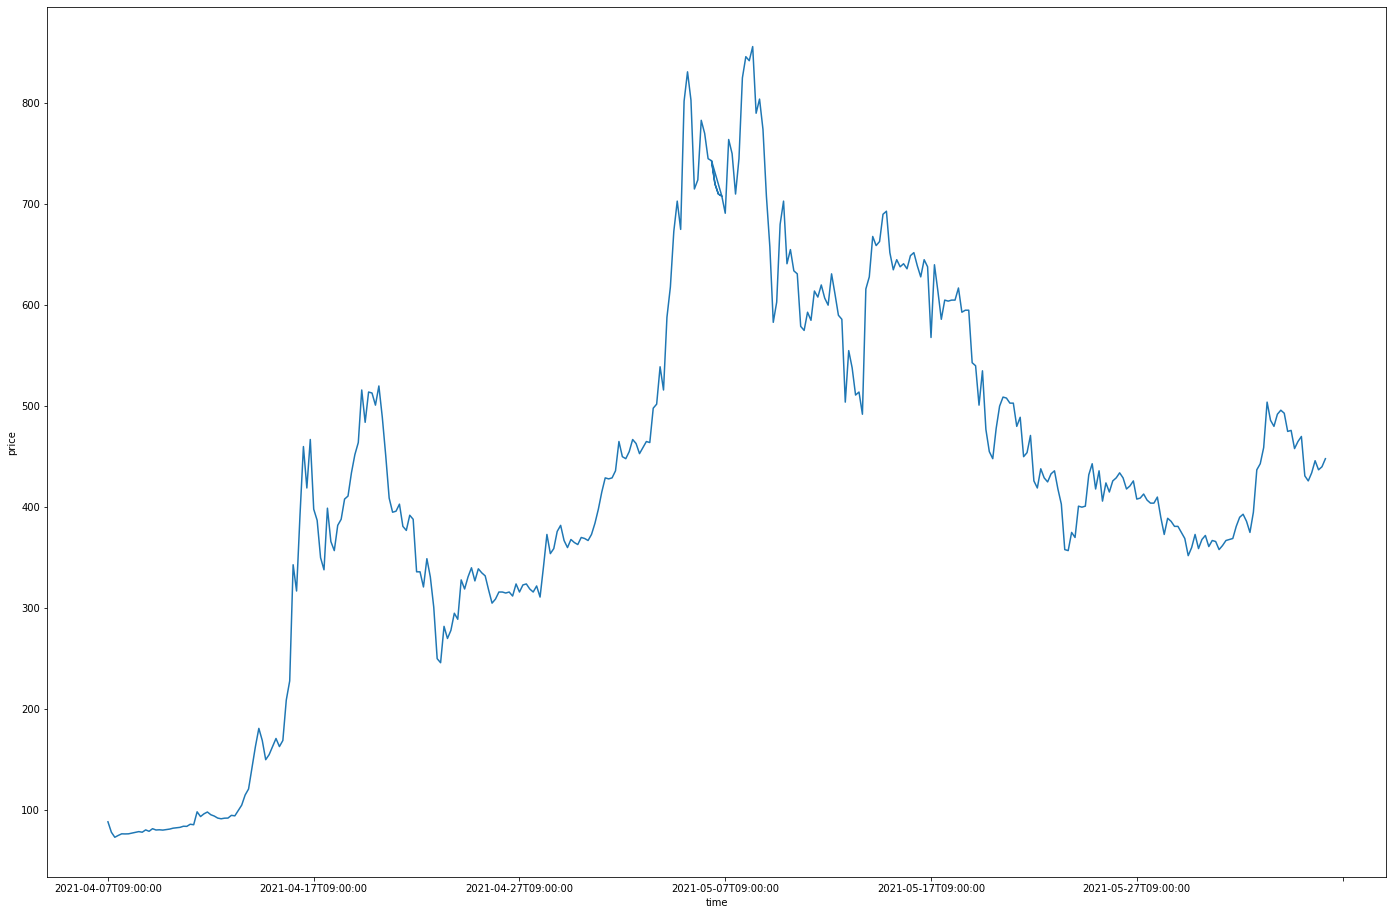

In [28]:
#데이터 자르기
df['candleDateTimeKst'] = df['candleDateTimeKst'].str.slice(start=0,stop=19).to_numpy() #string으로 넘어온 시간 데이터를 보기 편하게 잘라준다.
datachart = df['tradePrice']                                                            #y축에 사용할 수 있도록 가격데이터를 뽑아낸다. 추가적인 가공이 필요하다.
time = df['candleDateTimeKst'].to_numpy()                                               #x축에 사용할 수 있도록 시간데이터도 뽑아내준다.
length = len(datachart)-1


plt.figure(figsize=(24, 16))                                                            #화면 크기 지정, 실제 데이터의 형태를 그래프로 확인한다.
plt.plot(time, datachart)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))                                  #X축에 사용될 시간 데이터의 간격을 설정해줬다.
plt.xlabel('time')
plt.ylabel('price')

In [29]:
window_size = 6

def seq2dataset(datachart,window_size):                               #Lecture12 Window_Size 데이터 나누기 참고
    X = []; Y = []
    for i in range(len(datachart) - window_size):
        X.append(np.array(datachart.iloc[i:i+window_size]))
        Y.append(np.array(datachart.iloc[i+window_size]))
    return np.array(X), np.array(Y)



X, Y = seq2dataset(datachart,window_size);
X = X.reshape((X.shape[0], X.shape[1], 1))

Epoch 1/200
8/8 - 2s - loss: 438.4636 - mae: 438.4636 - val_loss: 359.1848 - val_mae: 359.1848
Epoch 2/200
8/8 - 0s - loss: 209.5894 - mae: 209.5894 - val_loss: 23.9147 - val_mae: 23.9147
Epoch 3/200
8/8 - 0s - loss: 40.0301 - mae: 40.0301 - val_loss: 19.5356 - val_mae: 19.5356
Epoch 4/200
8/8 - 0s - loss: 31.9951 - mae: 31.9951 - val_loss: 19.0580 - val_mae: 19.0580
Epoch 5/200
8/8 - 0s - loss: 30.6767 - mae: 30.6767 - val_loss: 19.5587 - val_mae: 19.5587
Epoch 6/200
8/8 - 0s - loss: 30.8332 - mae: 30.8332 - val_loss: 20.9079 - val_mae: 20.9079
Epoch 7/200
8/8 - 0s - loss: 30.2293 - mae: 30.2293 - val_loss: 15.3674 - val_mae: 15.3674
Epoch 8/200
8/8 - 0s - loss: 31.9136 - mae: 31.9136 - val_loss: 55.2190 - val_mae: 55.2190
Epoch 9/200
8/8 - 0s - loss: 36.6231 - mae: 36.6231 - val_loss: 18.8279 - val_mae: 18.8279
Epoch 10/200
8/8 - 0s - loss: 29.3708 - mae: 29.3708 - val_loss: 23.6838 - val_mae: 23.6838
Epoch 11/200
8/8 - 0s - loss: 33.8714 - mae: 33.8714 - val_loss: 25.9593 - val_mae:

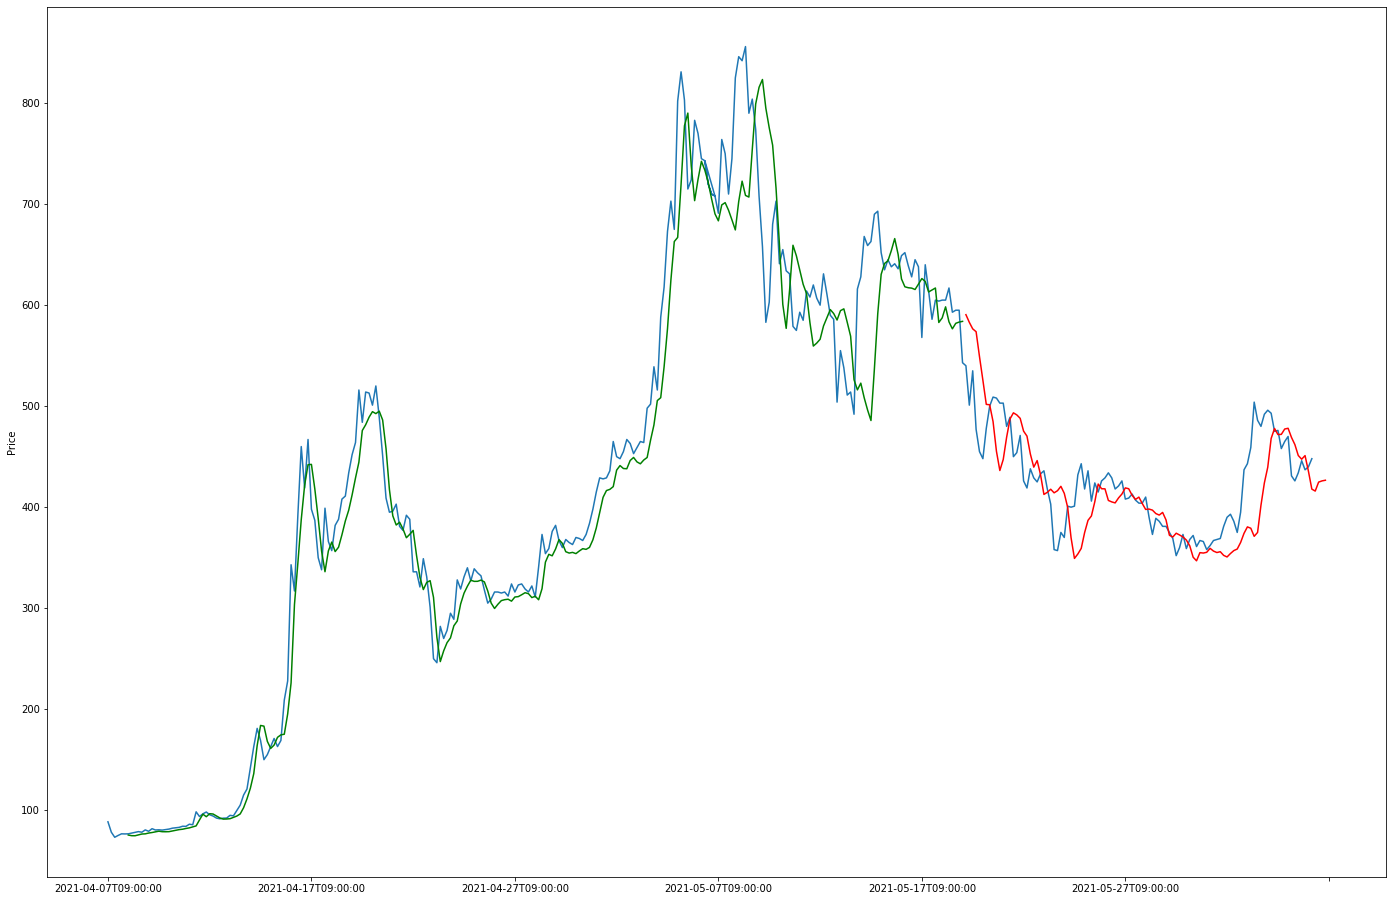

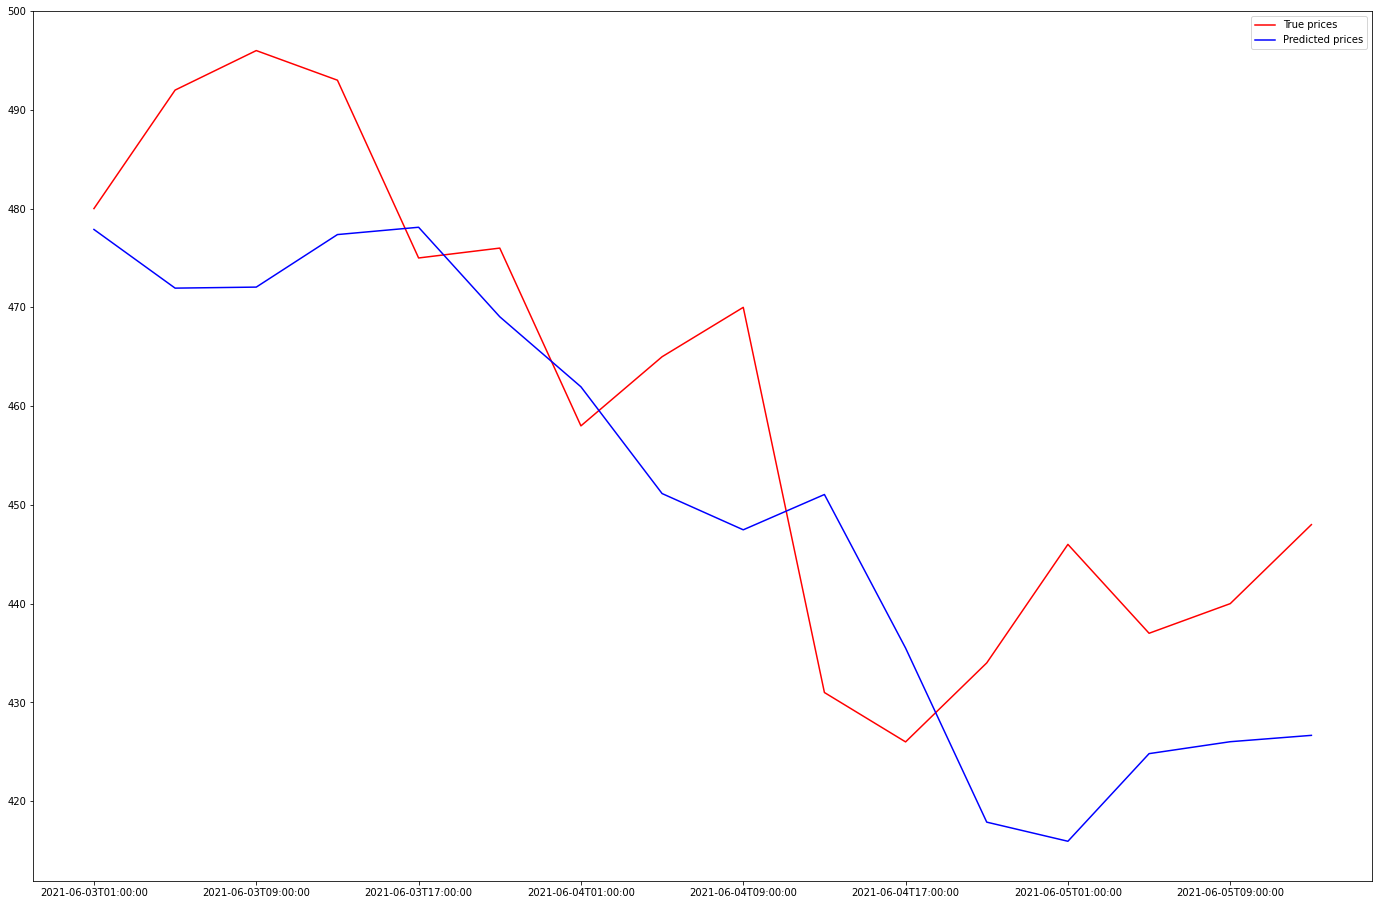

In [40]:
split = int(len(X)*0.7)                           #학습데이터(70%)와 테스트데이터(30%)로  나눔
x_train=X[0:split]; y_train=Y[0:split]
x_test=X[split:]; y_test=Y[split:]

model=Sequential()                                #학습모델 구축
model.add(LSTM(128,activation='relu',input_shape=(x_train.shape[1], x_train.shape[2], ))) #활성함수로는 relu 사용
model.add(Dense(1))
model.compile(loss='mae', optimizer='nadam', metrics=['mae']) #mae를 사용해야 특이값에 덜 민감하다.
model.fit(x_train, y_train, epochs=200,batch_size=32,validation_data=(x_test,y_test),verbose=2)
model.summary()

#예측
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)


#실제 데이터
plt.figure(figsize=(24, 16))
plt.plot(time, datachart)

#훈련 결과
split_tp = split + window_size
plt.plot(np.arange(window_size, split_tp, 1), train_predict, color='g')

#테스트 결과
plt.plot(np.arange(split_tp, split_tp + len(test_predict), 1), test_predict, color='r')

plt.ylabel('Price')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
plt.show()

#일부 데이터 확대
x_range = range(length - 15,length + 1)
plt.figure(figsize=(24, 16))
plt.plot(time[x_range], datachart[x_range],color='red')
plt.plot(time[x_range], test_predict[range(len(test_predict) - 16 ,len(test_predict))], color='blue')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend(['True prices', 'Predicted prices'], loc='best')
plt.show()

In [39]:
now = time[time.size - 1]
print("최근 시간 데이터 : ", now)


newdata = np.array(datachart.iloc[length + 1 - window_size:length+1])   #미래 예측을 위한 기존 데이터 추출
newdata = newdata.reshape((1, newdata.shape[0], 1))                     #3차원 데이터 변환 데이터 배열이 1개, 특징이 window_size개

newPredict = model.predict(newdata)
print("최근 가격 데이터 : ", datachart[length])
print("4시간 뒤 가격 예상 : ", newPredict)
sub = round(newPredict[0][0] - datachart[length], 2)
rate = round((newPredict[0][0]/datachart[length] - 1) * 100, 2)
if(sub > 0):
  print("예상 시간별 손익 : ", "+"+ str(sub))
else:
  print("예상 시간별 손익 : ", str(sub))
print("예상 수익률 : ", str(rate))

최근 시간 데이터 :  2021-06-05T13:00:00
최근 가격 데이터 :  448.0
4시간 뒤 가격 예상 :  [[438.52582]]
예상 시간별 손익 :  -9.47
예상 수익률 :  -2.11
